In [20]:
import tensorflow as tf


(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
assert x_train.shape == (60000, 28, 28)
assert x_test.shape == (10000, 28, 28)
assert y_train.shape == (60000,)
assert y_test.shape == (10000,)

x_train, x_test = x_train / 255., x_test / 255.

In [21]:
x_train, x_val = x_train[:50000], x_train[50000:]
y_train, y_val = y_train[:50000], y_train[50000:]

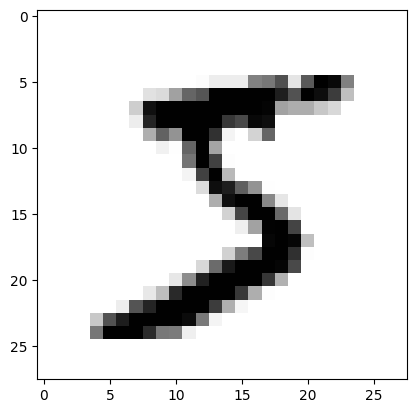

In [22]:
import matplotlib.pyplot as plt

plt.imshow(x_train[0], cmap='binary')
plt.show()

In [26]:
x_train.shape[1:]

(28, 28)

In [45]:
sequential_model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=x_train.shape[1:]),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units = 300, activation='relu'),
    tf.keras.layers.Dense(units=100,activation='relu'),
    tf.keras.layers.Dense(units = 10, activation='softmax')
])
sequential_model.compile(
    optimizer=tf.keras.optimizers.SGD(learning_rate=1e-3),
    loss=tf.keras.losses.sparse_categorical_crossentropy,
    metrics = [tf.keras.metrics.sparse_categorical_accuracy]
)

In [46]:
from pathlib import Path
from time import strftime

tf.random.set_seed(42)

def scheduler(epoch,lr):
    if epoch < 10:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

def get_logs_dir():
    return Path('log_dir') / strftime("run_%Y_%m_%d_%H_%M_%S")

run_log_dir = get_logs_dir()

early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=5,
                                                     restore_best_weights=True)
lr_callback = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    patience=5,
    factor=0.1,
)

tensorboard_cb = tf.keras.callbacks.TensorBoard(log_dir=run_log_dir)

history = sequential_model.fit(
    x_train,
    y_train,
    validation_data=(x_val,y_val),
    callbacks=[early_stopping_cb,lr_callback, tensorboard_cb],
    epochs=50
)

Epoch 1/50
1563/1563 [==============================] - 9s 5ms/step - loss: 1.7680 - sparse_categorical_accuracy: 0.5344 - val_loss: 1.2242 - val_sparse_categorical_accuracy: 0.7561 - lr: 0.0010
Epoch 2/50
1563/1563 [==============================] - 9s 6ms/step - loss: 0.9479 - sparse_categorical_accuracy: 0.7915 - val_loss: 0.7004 - val_sparse_categorical_accuracy: 0.8455 - lr: 0.0010
Epoch 3/50
1563/1563 [==============================] - 8s 5ms/step - loss: 0.6421 - sparse_categorical_accuracy: 0.8476 - val_loss: 0.5232 - val_sparse_categorical_accuracy: 0.8750 - lr: 0.0010
Epoch 4/50
1563/1563 [==============================] - 8s 5ms/step - loss: 0.5197 - sparse_categorical_accuracy: 0.8692 - val_loss: 0.4411 - val_sparse_categorical_accuracy: 0.8892 - lr: 0.0010
Epoch 5/50
1563/1563 [==============================] - 8s 5ms/step - loss: 0.4548 - sparse_categorical_accuracy: 0.8817 - val_loss: 0.3945 - val_sparse_categorical_accuracy: 0.8985 - lr: 0.0010
Epoch 6/50
1563/1563 [===

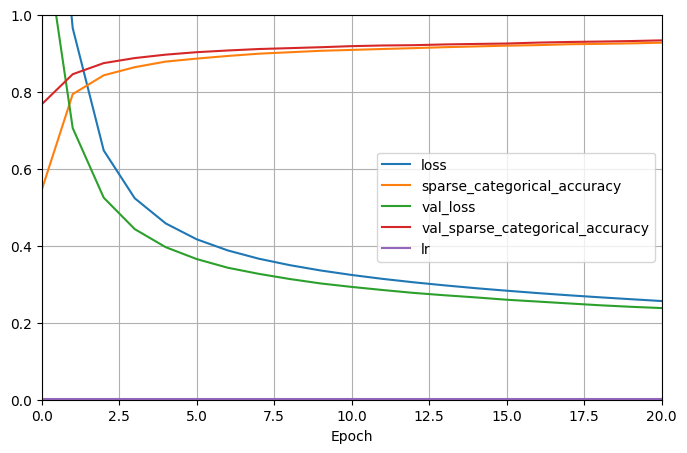

In [44]:
import pandas as pd

history_df = pd.DataFrame(history.history)

history_df.plot(figsize=(8,5), xlabel='Epoch', grid=True, xlim=[0,20],ylim=[0,1])
plt.show()

In [66]:
import keras_tuner

def build_model(hp):
  model = tf.keras.Sequential([
      tf.keras.layers.Input(shape=x_train.shape[1:]),
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(units = hp.Choice('units1', [300,250,200]), activation='relu'),
      tf.keras.layers.Dense(units = hp.Choice('units2', [100,75,50]),activation='relu'),
  ])
  if hp.Boolean("dropout"):
    model.add(tf.keras.layers.Dropout(rate=0.25))
  
  model.add(tf.keras.layers.Dense(units = 10, activation='softmax'))
  
  model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss=tf.keras.losses.sparse_categorical_crossentropy,
    metrics=tf.keras.metrics.sparse_categorical_accuracy
  )
  return model


tuner = keras_tuner.BayesianOptimization(
  hypermodel=build_model,
  objective="val_sparse_categorical_accuracy",
  max_trials=3,
  overwrite=True,
)

In [67]:
tuner.search(x_train[:5000], y_train[:5000], epochs=5, validation_data=(x_val, y_val))
# Get the top 2 models.
models = tuner.get_best_models(num_models=2)
best_model = models[0]

Trial 3 Complete [00h 00m 08s]
val_sparse_categorical_accuracy: 0.9423999786376953

Best val_sparse_categorical_accuracy So Far: 0.9452999830245972
Total elapsed time: 00h 00m 23s
INFO:tensorflow:Oracle triggered exit


In [68]:
best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 300)               235500    
                                                                 
 dense_1 (Dense)             (None, 100)               30100     
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense_2 (Dense)             (None, 10)                1010      
                                                                 
Total params: 266,610
Trainable params: 266,610
Non-trainable params: 0
_________________________________________________________________


In [71]:
top_params = tuner.get_best_hyperparameters()
top_params[0].values

{'units1': 300, 'units2': 100, 'dropout': True}

In [72]:
history = best_model.fit(
    x_train,
    y_train,
    validation_data=(x_val,y_val),
    callbacks=[tensorboard_cb, lr_callback, early_stopping_cb],
    epochs=50, 
)

Epoch 1/50
1563/1563 [==============================] - 8s 5ms/step - loss: 0.1666 - sparse_categorical_accuracy: 0.9499 - val_loss: 0.1102 - val_sparse_categorical_accuracy: 0.9664 - lr: 0.0010
Epoch 2/50
1563/1563 [==============================] - 7s 5ms/step - loss: 0.0957 - sparse_categorical_accuracy: 0.9706 - val_loss: 0.1040 - val_sparse_categorical_accuracy: 0.9692 - lr: 0.0010
Epoch 3/50
1563/1563 [==============================] - 7s 5ms/step - loss: 0.0660 - sparse_categorical_accuracy: 0.9787 - val_loss: 0.0806 - val_sparse_categorical_accuracy: 0.9766 - lr: 0.0010
Epoch 4/50
1563/1563 [==============================] - 7s 5ms/step - loss: 0.0526 - sparse_categorical_accuracy: 0.9839 - val_loss: 0.0856 - val_sparse_categorical_accuracy: 0.9768 - lr: 0.0010
Epoch 5/50
1563/1563 [==============================] - 7s 5ms/step - loss: 0.0412 - sparse_categorical_accuracy: 0.9864 - val_loss: 0.0915 - val_sparse_categorical_accuracy: 0.9763 - lr: 0.0010
Epoch 6/50
1563/1563 [===

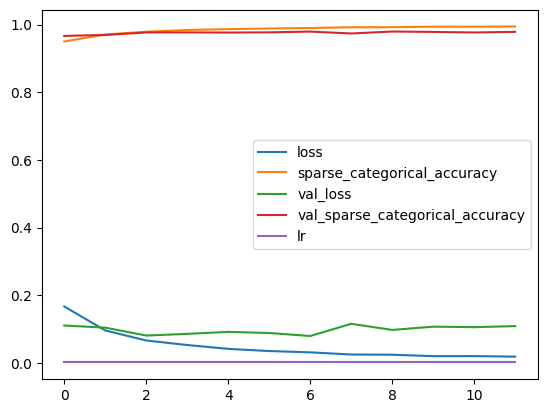

In [73]:
pd.DataFrame(history.history).plot()

plt.show()

In [74]:
best_model.evaluate(x_test,y_test)

313/313 [==============================] - 1s 2ms/step - loss: 0.0718 - sparse_categorical_accuracy: 0.9809


[0.07175406068563461, 0.98089998960495]

In [78]:
tf.keras.models.save_model(best_model,'best_model')

INFO:tensorflow:Assets written to: best_model/assets


INFO:tensorflow:Assets written to: best_model/assets


In [79]:
recovered_model = tf.keras.models.load_model('best_model')